# Learning by doing: ISLP (ISLR python version) 

## Intro

By Learning ISLR book, it was decided to learn by doing more practical stuff. The first target is finding similiar simple topic in Kaggle to pracitise what I read in book, and discover what I did not notice by just reading.

## 03 Linear Regression

### Reference 

There are plenty of good kernels which helps me alot during the Kaggle journey. 

* [Trying out a linear model](https://www.kaggle.com/apapiu/regularized-linear-models) 
* [COMPREHENSIVE DATA EXPLORATION WITH PYTHON](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by ([@apapiu](https://twitter.com/apapiu), [GitHub](https://github.com/apapiu))
* [Stacked Regressions to predict House Prices](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
* [房价预测kaggle入门项目](https://www.kaggle.com/marsggbo/kaggle)
* [Python机器学习中的实用小操作(一)：数据清理篇](https://zhuanlan.zhihu.com/p/29893734)
* [用python参加Kaggle的些许经验总结](https://www.jianshu.com/p/32def2294ae6)

If you use parts of this notebook in your own scripts, please give some sort of credit (for example link back to this). Thanks!


### Preprations for notebook
Some general preparation for import and plot.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

#%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

### Prepration for datasets via kaggle API.
By using kaggle api, it could be very cozy to dowload the needed datasets in terminal, which provides the possiblity to utilize clould infrustructor like GCC or AWS.

```bash
kaggle competitions download house-prices-advanced-regression-techniques
```

Refer [Kaggle API](https://github.com/Kaggle/kaggle-api) for more details about installation,  general config and other commands.

### Define the datasets and check the status

In [3]:
import os
import sys
if sys.platform == "linux":
    path = "../input/"
else:
    root = os.getcwd()
    path = os.path.join(root, "../../competitions/house-prices-advanced-regression-techniques/")
    path = os.path.realpath(path)+"/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [87]:
train.head() # or open 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Refer the handy [cheatsheet](http://pandas.pydata.org/Pandas_Cheat_Sheet.pdf) for general df operations in pandas.

* Concation of all data, refer [pandas merge guide](http://pandas.pydata.org/pandas-docs/stable/merging.html) for more details.

* [Data Fram column selection](http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-label) is done by df.loc[:,"row_x":"row_y"].



In [5]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

## Flow of resolving kaggle competition

A general guide to follow here is recorded in onenote:

1. Step 1: Exploratory Data Analysis
2. Step 2: Data Preprocessing
3. Step 3: Feature Engineering
4. Step 4: Model Selection and Training
5. Step 5: Model Ensemble
6. Step 6: Other Tips

There would be several detailed description in this regression problem


###  Step 1: Exploratory Data Analysis



#### Check feature & lable's  mean, status, type



In [86]:
train.describe()
features = train.columns.tolist()
# 对数据进行基本的检查
# 得到数据的形状
n_df = train.shape[0]
print ("共有{row}行{col}列数据".format(
        row=train.shape[0],
        col=train.shape[1]))
## local check
## list all unique value in features, double check with data_description.txt in data files 
#for i in features:
#    print(i,":",train[i].unique())

#descriptive statistics summary and other data
train.describe() 
train['SalePrice'].describe() #highlight lable status

共有1460行81列数据


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### Check the missing data

Important questions when thinking about missing data:
* How prevalent is the missing data?
* Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

In [85]:
#check certain feature by column name or feature name
#train.Alley.isnull()
train.loc[train.Alley.isnull(),'Alley']
train.loc[train['Alley'].isnull(),'Alley']

## local check
## check all features which has missing value
#for i in features:
#    print(i,":", train.loc[train[i].isnull(),i])

#missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

## 1. 检查缺失值
## 计算每个变量的缺失值
#for col in features:
#    missing = n_df - np.count_nonzero(train[col].isnull().values)
#    mis_perc = 100 - float(missing) / n_df * 100 
#    print ("{col}的缺失比例是:\t{miss}%".format(col=col,miss=mis_perc))

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


#### Check the data distribution by boxplot or hist



##### Charactoristics of lable "sale price" 

Spending time to digg into the lable of train train is 1st priority. Its charactoristics is worthy to invest, such as distribution



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120b1af28>,
      dtype=object)

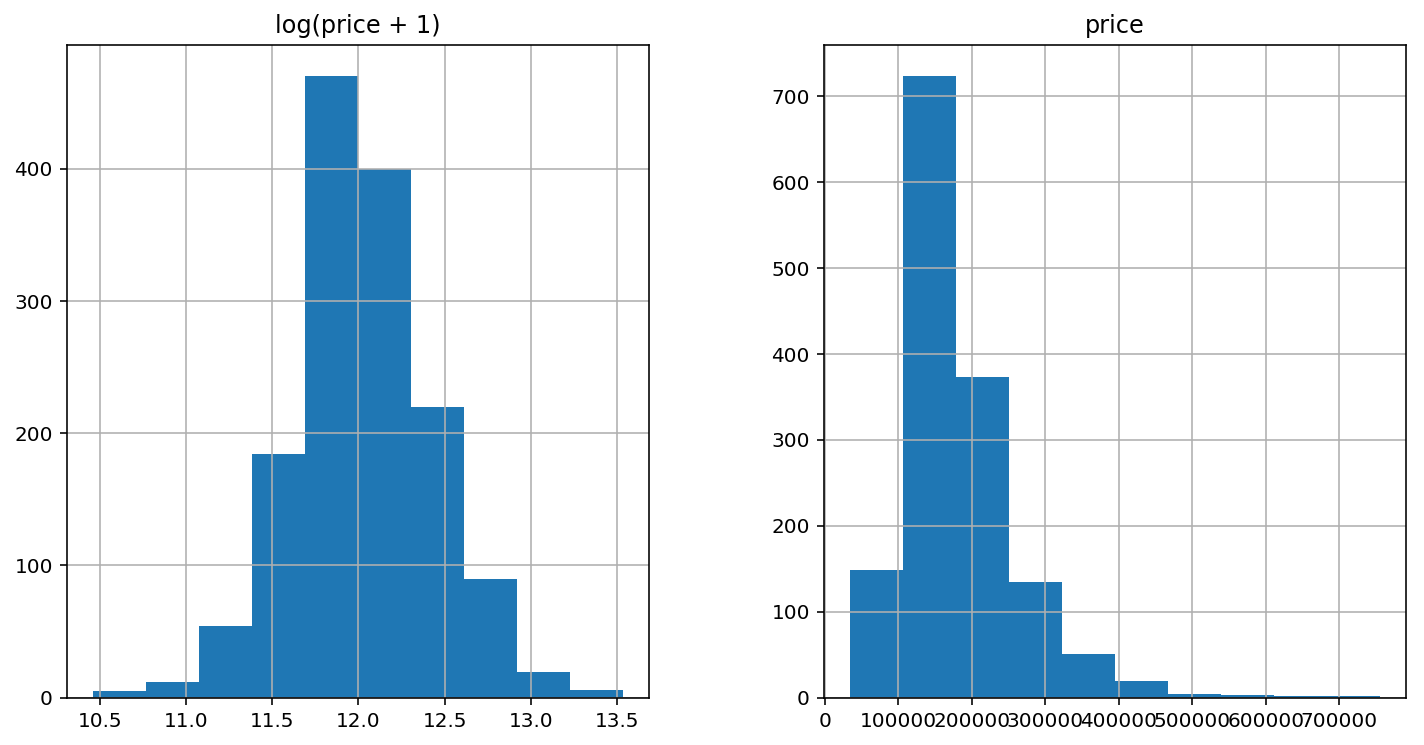

In [18]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()


 
- <span class="burk">Or, transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal</span>  



可以看到与使用matplotlib作的直方图最大的区别在于有一条密度曲线（KDE），可以通过设置参数去掉这条默认的曲线。 另外由上图可以知道房价呈现正态分布。下面还可以看到两个统计学中的概念： **峰度（Kurtosis）**和 **偏度（Skewness）**。

**峰度：峰度（Kurtosis）是描述某变量所有取值分布形态陡缓程度的统计量。**

它是和正态分布相比较的。

* $Kurtosis=0$ 与正态分布的陡缓程度相同。
* $Kurtosis>0$ 比正态分布的高峰更加陡峭——尖顶峰
* $Kurtosis<0$ 比正态分布的高峰来得平台——平顶峰计算公式：$β = M_4/σ^4$ 偏度：

**偏度：偏度（Skewness）是描述某变量取值分布对称性的统计量。**

* $Skewness=0$ 分布形态与正态分布偏度相同
* $Skewness>0$ 正偏差数值较大，为正偏或右偏。长尾巴拖在右边。
* $Skewness<0$ 负偏差数值较大，为负偏或左偏。长尾巴拖在左边。 计算公式： $S= (X^ - M_0)/δ$ Skewness 越大，分布形态偏移程度越大。

skew定义

偏度（skewness），是统计数据分布偏斜方向和程度的度量，是统计数据分布非对称程度的数字特征。偏度(Skewness)亦称偏态、偏态系数。 
表征概率分布密度曲线相对于平均值不对称程度的特征数。直观看来就是密度函数曲线尾部的相对长度。 
定义上偏度是样本的三阶标准化矩?： 
\begin{equation}
skew(X) = E[(\frac{X−μ}{σ})^3]
\end{equation}


/Users/monkeyxite/.virtualenvs/py3ml/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Skewness: 1.882876 . After log, Skewness: 0.121347
Kurtosis: 6.536282 . After log, Kurtosis: 0.809519


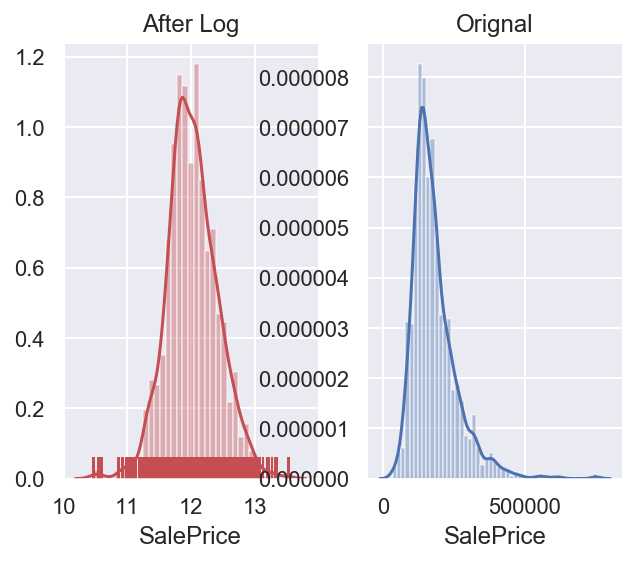

In [88]:
f, axes = plt.subplots(1, 2,  sharex=False,figsize=(5,4))
sns.despine(left=True)
axes[0].set_title('After Log')
axes[1].set_title('Orignal')
sns.distplot(np.log1p(train["SalePrice"]), rug=True, color="r", ax=axes[0])
sns.distplot(train["SalePrice"], ax=axes[1])
#plt.setp(axes, yticks=[])
#plt.tight_layout()

#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew(),". After log, Skewness: %f" % np.log1p(train['SalePrice']).skew())
print("Kurtosis: %f" % train['SalePrice'].kurt(), ". After log, Kurtosis: %f" % np.log1p(train['SalePrice']).kurt())




##### Characteristics of features

Then we should take some time for each feature, the distirbution, mean, and so on

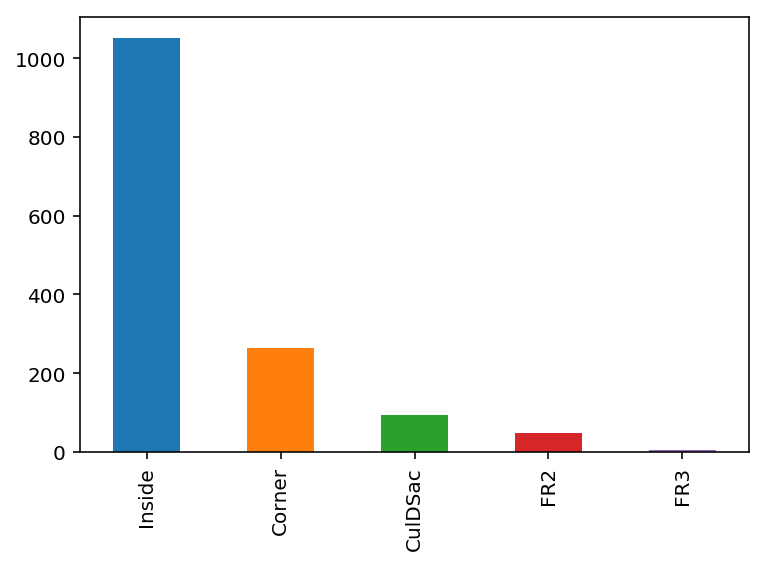

In [13]:
#box plot feature Y group by feature X
#train.boxplot(column='SalePrice', by="MiscVal")

#histogram for numberic feature
#train['YrSold'].hist()
#distribution ofr categorical feature
train['LotConfig'].value_counts().plot(kind='bar')

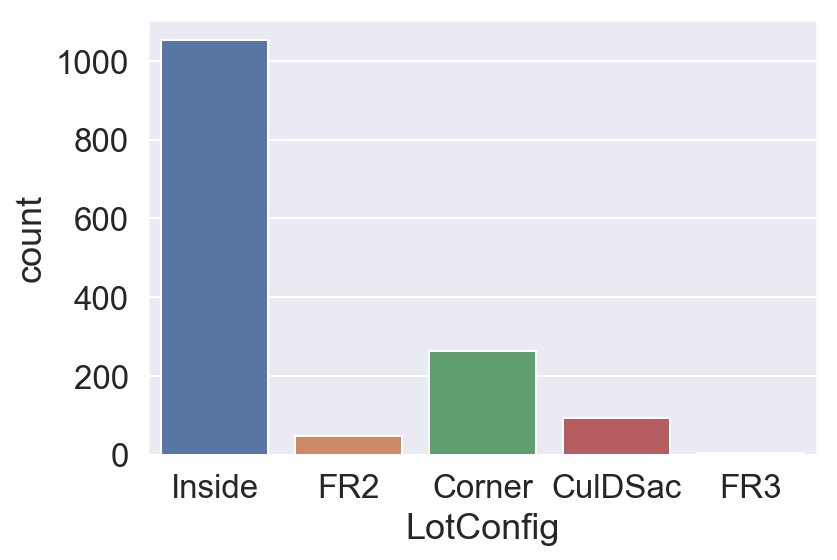

In [55]:
sns.countplot(train['LotConfig'])
#seaborn.barplot(x=train['LotConfig'].value_counts().index, y=train['LotConfig'].value_counts())

#### Check the cross relationship, by using pands groupby?

Corraltion vs covariance
\begin{equation}
cov(X,Y)=E(X-E(X))E(Y-E(Y))=E(XY)-E(X)E(Y)\\
D(X)=(E(X-E(X)))^2\\
\rho = (cov(X,Y))/(\sqrt{D(X)}\sqrt{D(Y)})
\end{equation}

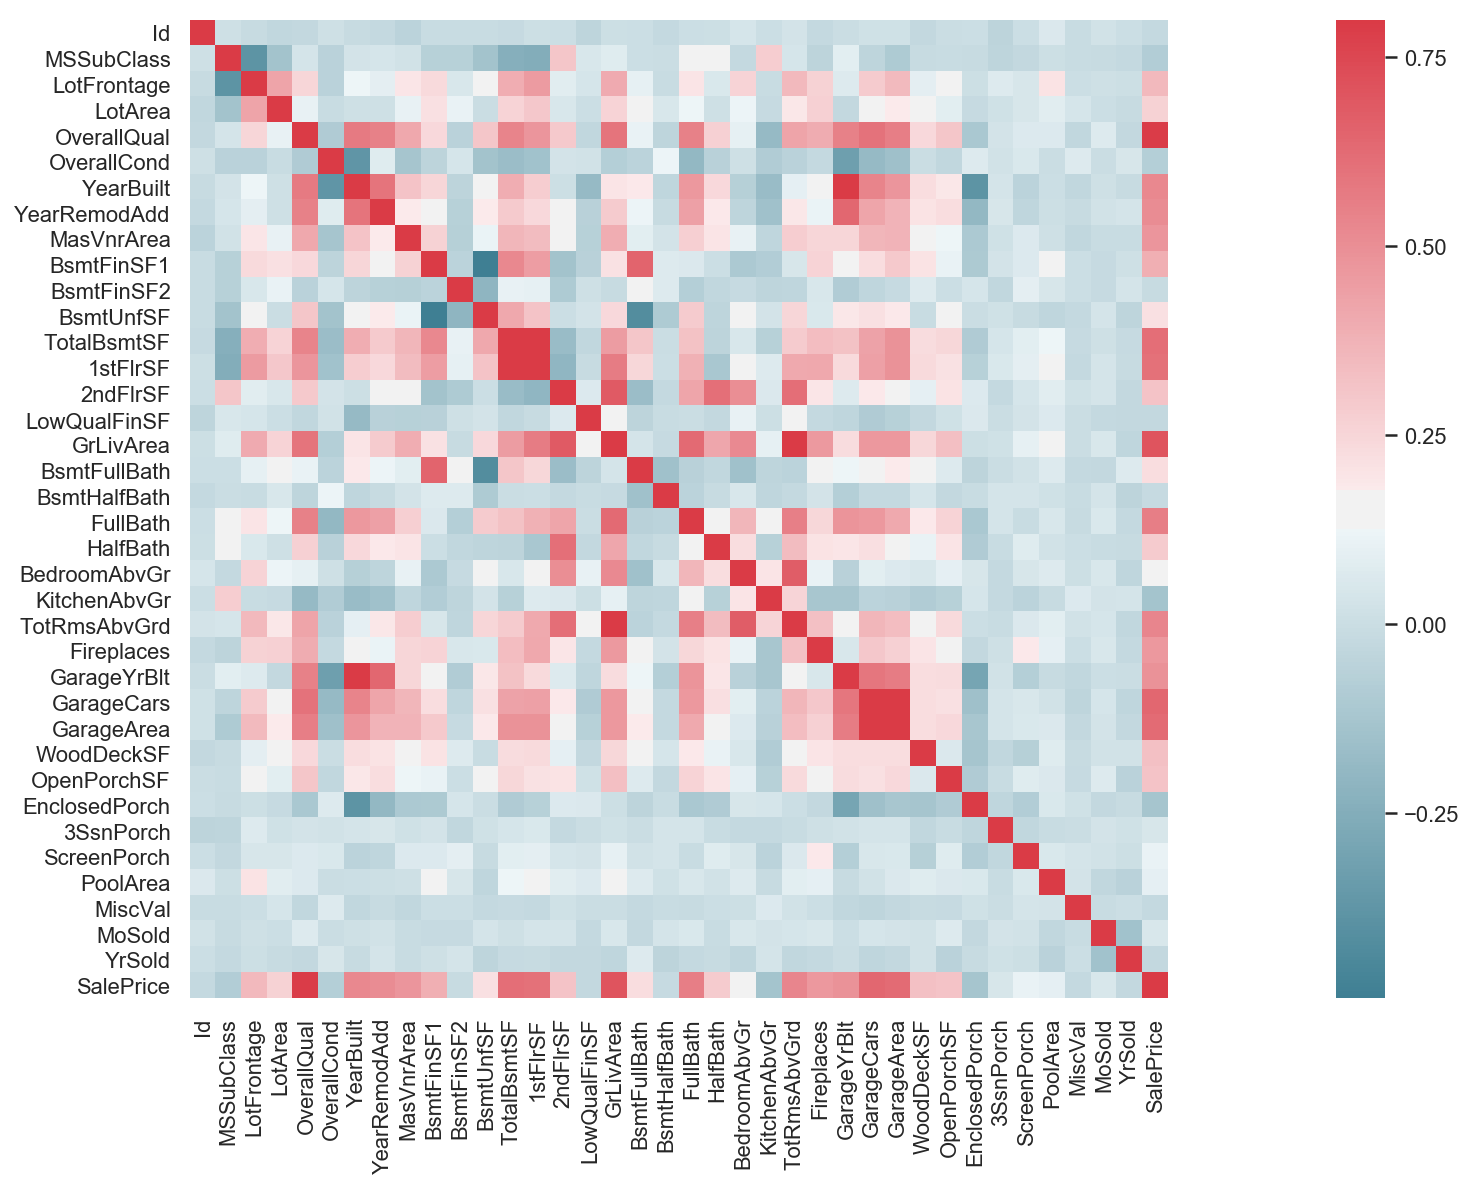

In [62]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(30, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrmat, vmax=0.8, cmap=cmap, square=True)

Above heatmap only contains the numberic feature, simple ajustment would help for feature engineering.

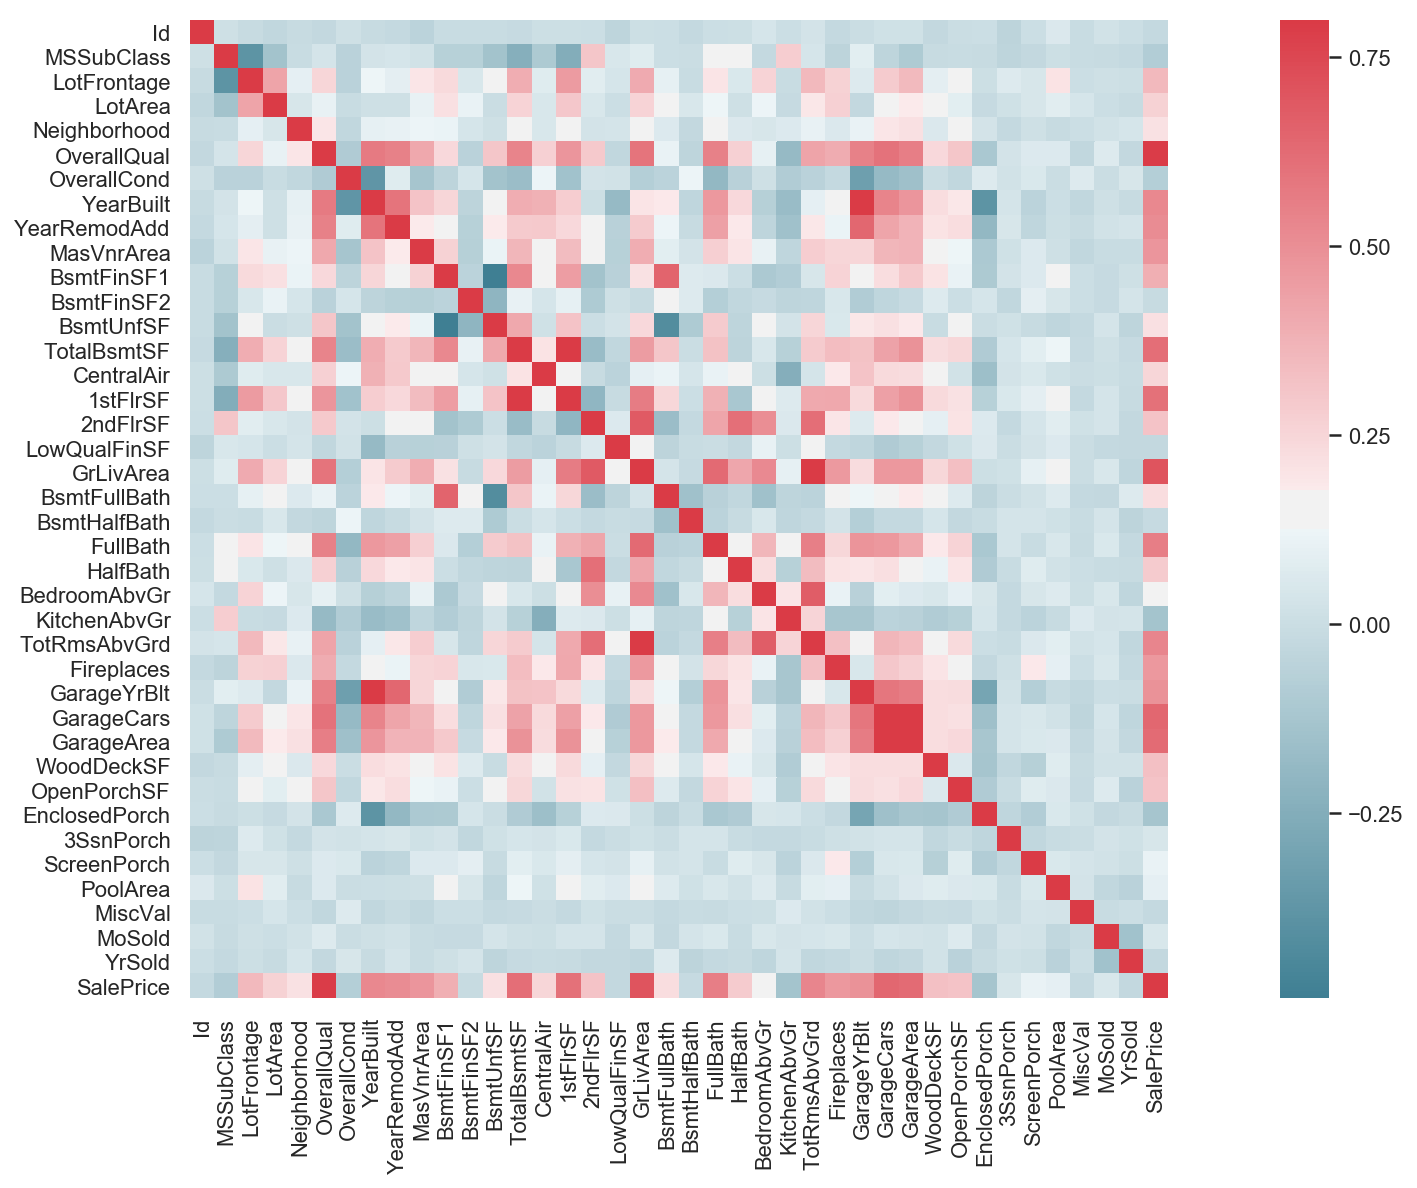

In [64]:
from sklearn import preprocessing
f_names = ['CentralAir', 'Neighborhood']
for x in f_names:
    label = preprocessing.LabelEncoder()
    train[x] = label.fit_transform(train[x])
corrmat = train.corr()
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(corrmat, vmax=0.8, cmap=cmap, square=True)

#### Corelation matrix to price

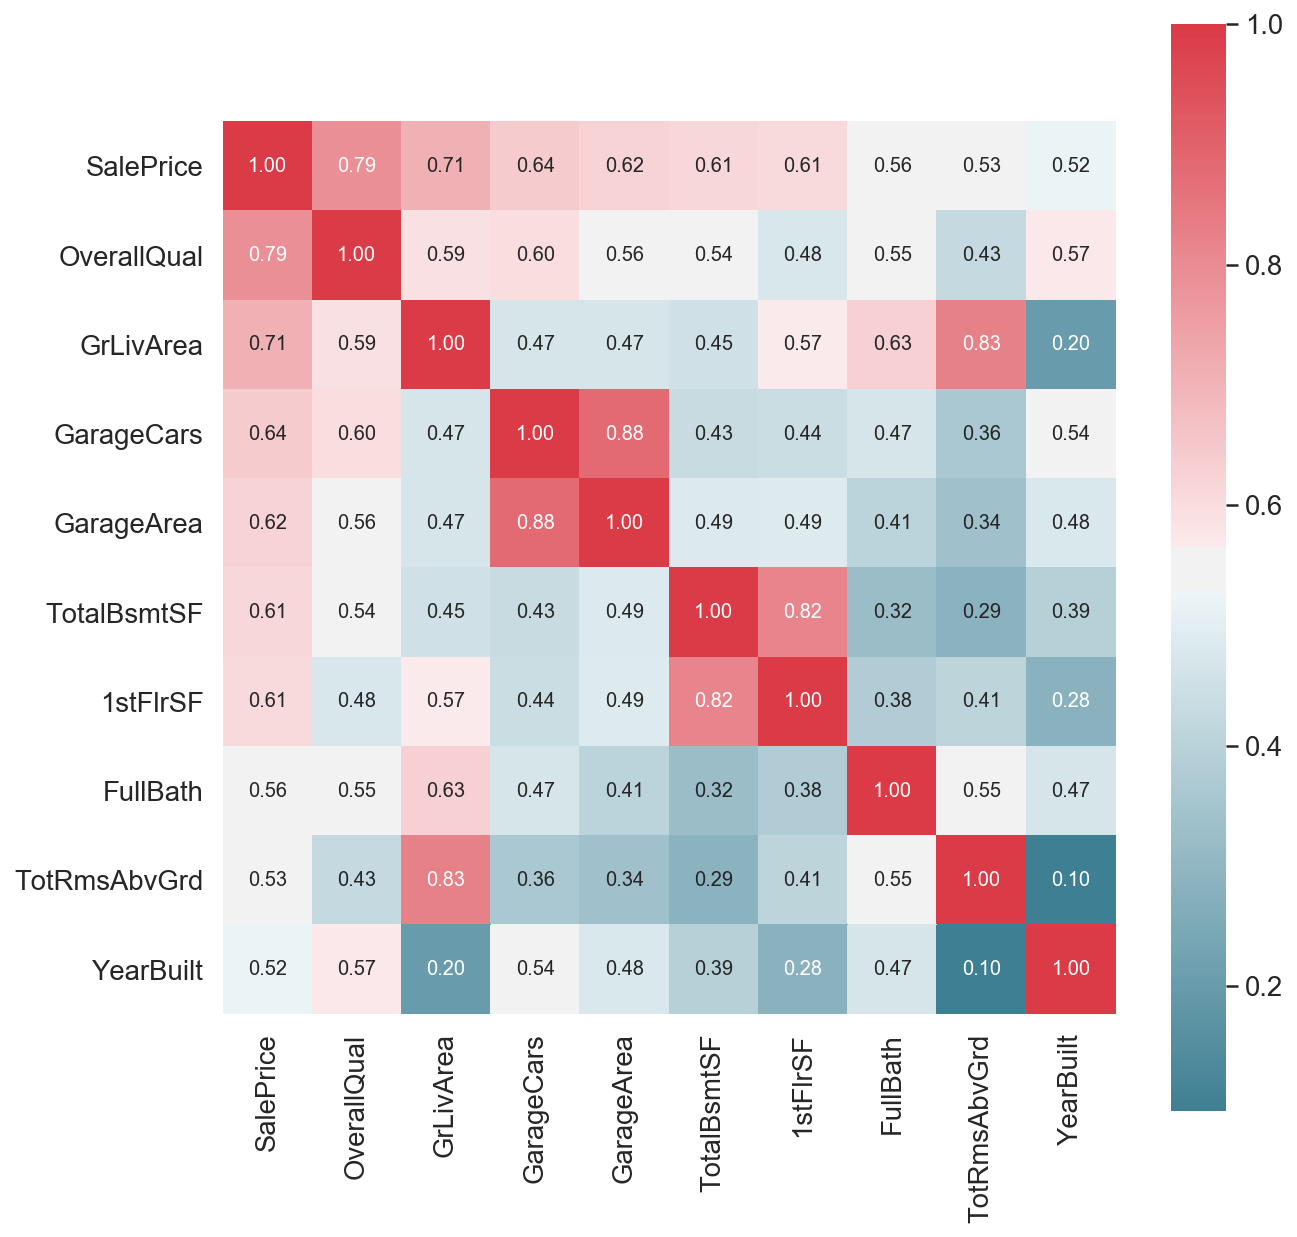

In [80]:
k  = 10 # 关系矩阵中将显示10个特征
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', cmap=cmap, annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Plot Pairplot 
绘制关系点图

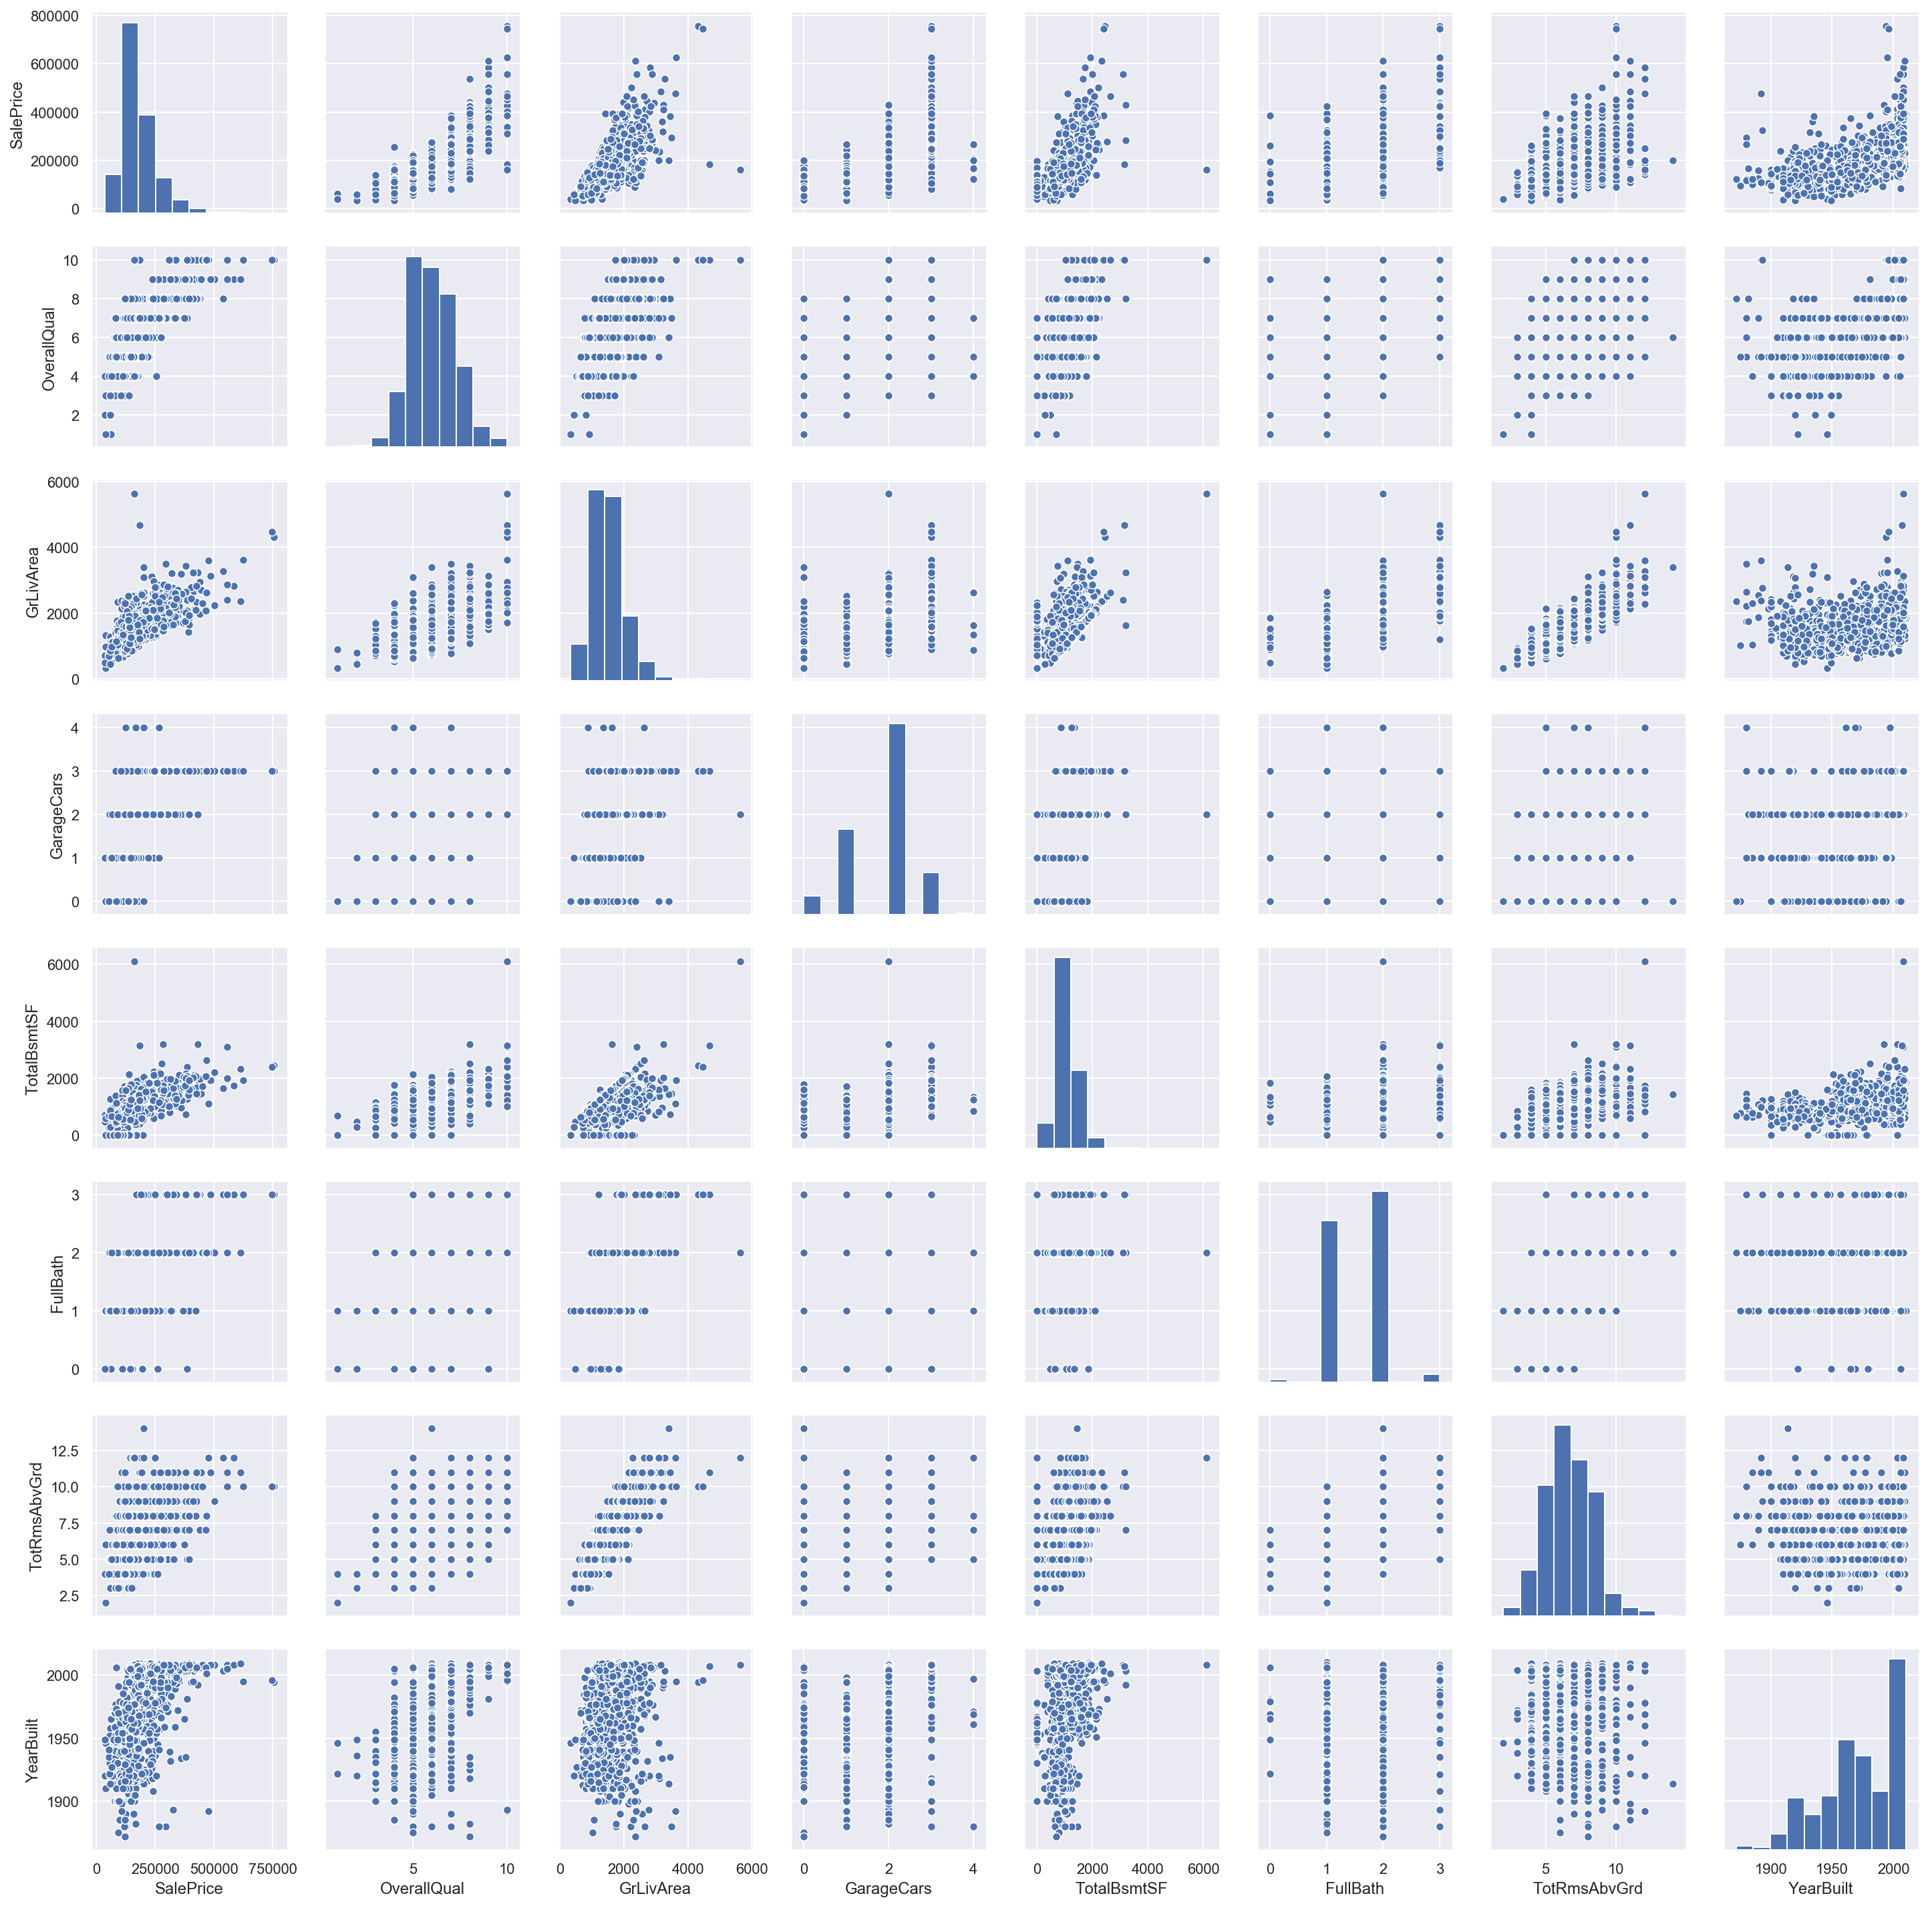

In [82]:
sns.set()
cols = ['SalePrice','OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)
plt.show()

#### 1-to-1 plot about feature and labling to dig for more details

The pairplot could give you a peak about general information, if you intend to get more details you could make more plots.

##### Relationship with numerical variables


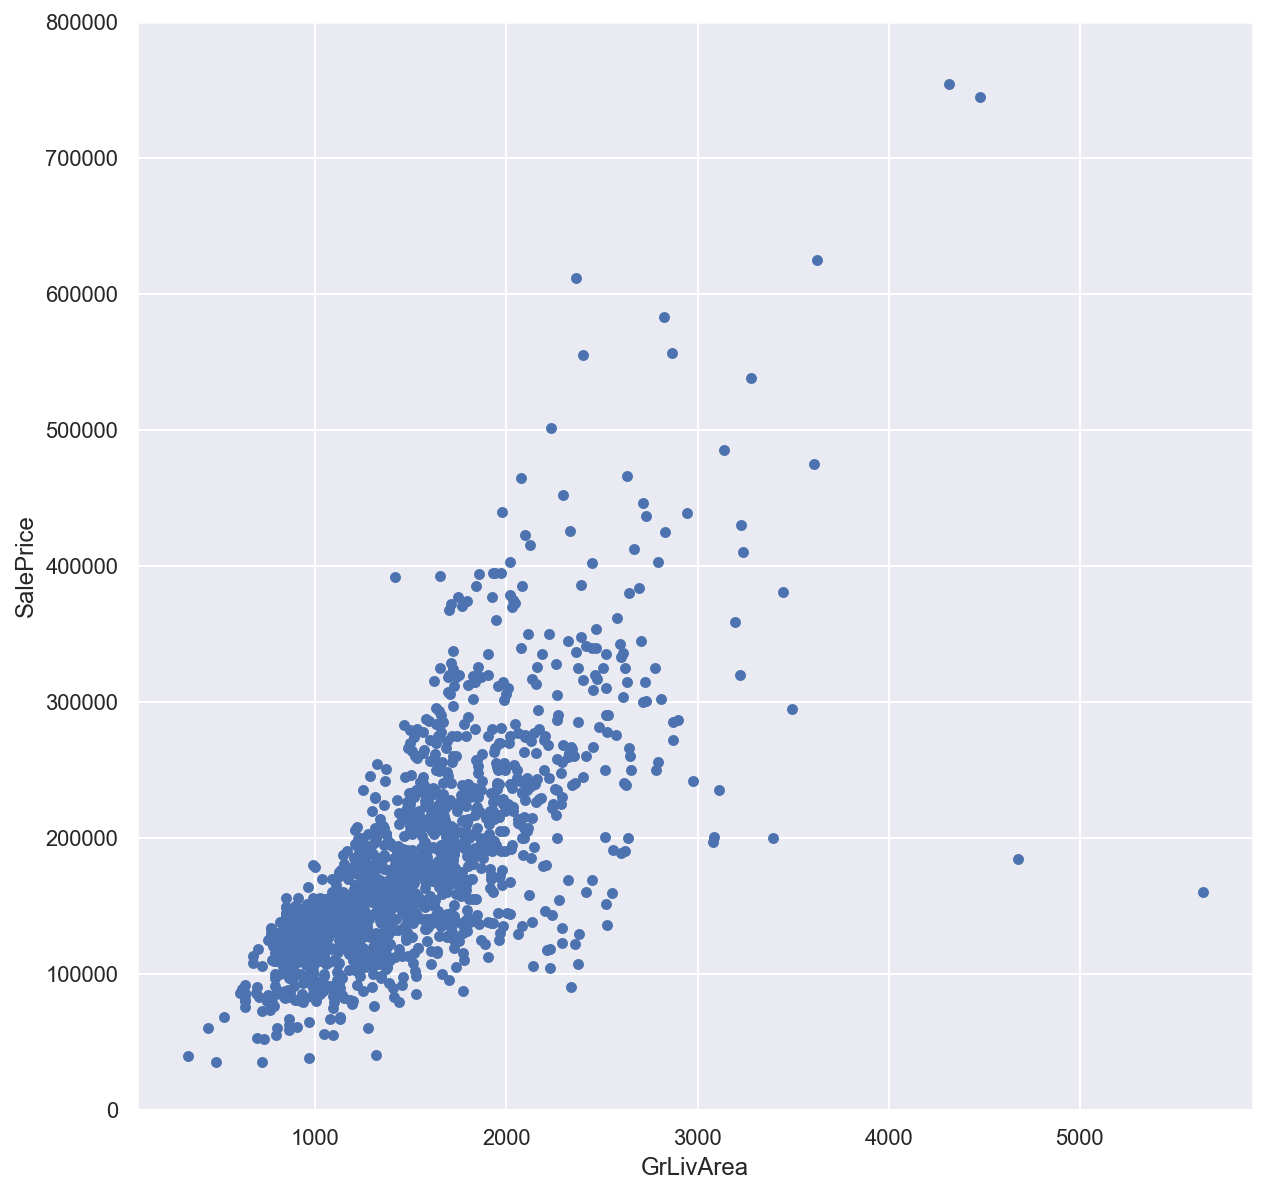

In [91]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

##### Relationship with categorical features

You could using box plot for more var likt 'overallqual' , 'fullbath', or any other categorical (描述性) feature .

Appearantly, boxplot provides more details other than scatter in pairplot.


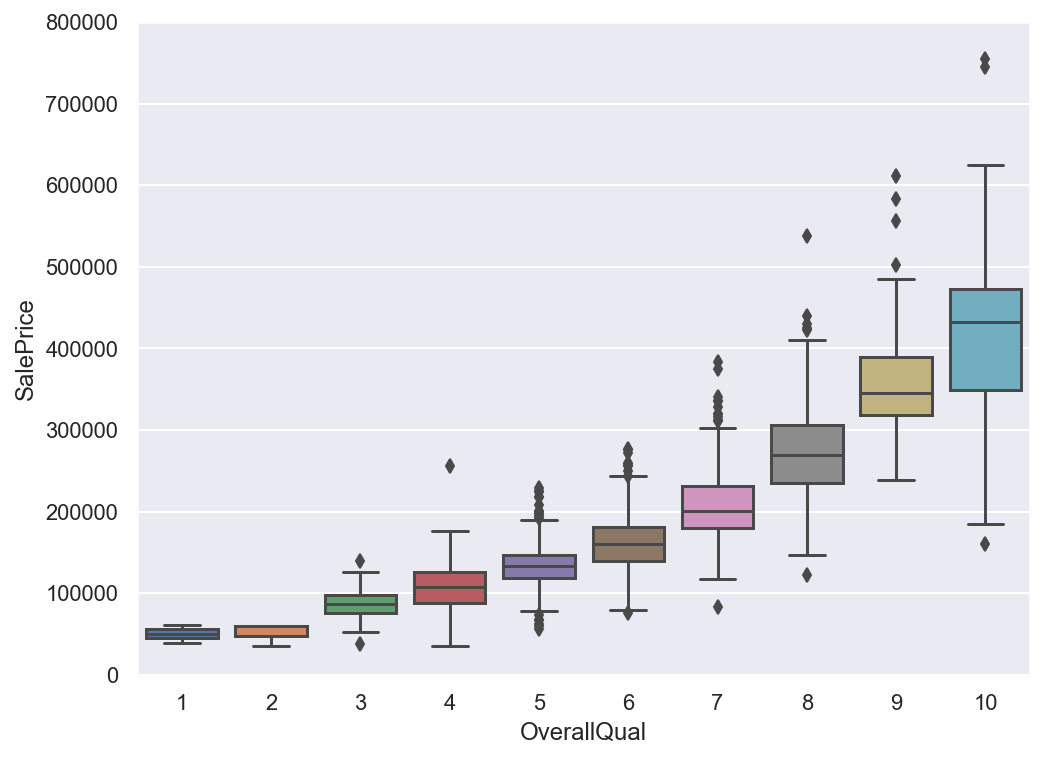

In [93]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);


###  Step 2: Data preprocessing / Feature Engineering
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

In [31]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [ ]:
all_data = pd.get_dummies(all_data)

In [ ]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [ ]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Models

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization
parameter that measures how flexible our model is. The higher the regularization
the less prone our model will be to overfit. However it will also lose
flexibility and might not capture all of the signal in the data.

In [ ]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

In [ ]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is
too strong and the model cannot capture all the complexities in the data. If
however we let the model be too flexible (alpha small) the model begins to
overfit. A value of alpha = 10 is about right based on the plot above.

In [ ]:
cv_ridge.min()

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the
Lasso model. We will do a slightly different approach here and use the built in
Lasso CV to figure out the best alpha for us. For some reason the alphas in
Lasso CV are really the inverse or the alphas in Ridge.

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [ ]:
rmse_cv(model_lasso).mean()

Nice! The lasso performs even better so we'll just use this one to predict on
the test set. Another neat thing about the Lasso is that it does feature
selection for you - setting coefficients of features it deems unimportant to
zero. Let's take a look at the coefficients:

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Good job Lasso.  One thing to note here however is that the features selected
are not necessarily the "correct" ones - especially since there are a lot of
collinear features in this dataset. One idea to try here is run Lasso a few
times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is `GrLivArea` -  the above ground area by
area square feet. This definitely sense. Then a few other  location and quality
features contributed positively. Some of the negative features make less sense
and would be worth looking into more - it seems like they might come from
unbalanced categorical variables.

 Also note that unlike the feature importance
you'd get from a random forest these are _actual_ coefficients in your model -
so you can say precisely why the predicted price is what it is. The only issue
here is that we log_transformed both the target and the numeric features so the
actual magnitudes are a bit hard to interpret.

In [ ]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good.To wrap it up let's predict on the test set
and submit on the leaderboard:

### Adding an xgboost model:

Let's add an xgboost model to our linear model to see if we can improve our
score:

In [ ]:
import xgboost as xgb

In [ ]:

dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [ ]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

In [ ]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [ ]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

Many times it makes sense to take a weighted average of uncorrelated results -
this usually imporoves the score although in this case it doesn't help that
much.

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [ ]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

### Trying out keras?

Feedforward Neural Nets doesn't seem to work well at
all...I wonder why.

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X_train = StandardScaler().fit_transform(X_train)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

In [ ]:
X_tr.shape

In [ ]:
X_tr

In [ ]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

In [ ]:
model.summary()

In [ ]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

In [ ]:
pd.Series(model.predict(X_val)[:,0]).hist()